# L5: Fast AI Agents with a Semantic Cache

In this final lab, you’ll integrate your semantic cache into an AI agent so it can reuse past results, skip redundant work, and get faster over time.

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Setup Environment

In [2]:
from cache.llm_evaluator import set_openai_key

set_openai_key()

In [3]:
import logging
import time
import json
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any, Optional

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END, START

import redis
from redisvl.utils.vectorize import HFTextVectorizer, OpenAITextVectorizer
from redisvl.extensions.cache.llm import SemanticCache
from redisvl.index import SearchIndex
from redisvl.query import VectorQuery

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger("agentic-workflow")

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>
</div>

## Setup Redis Infra

In [4]:
redis_client = redis.Redis.from_url(
    "redis://localhost:6379", decode_responses=False
)
redis_client.ping()

True

### Build the Agent Knowledge Base (for RAG)


In [5]:
from agent import create_knowledge_base_from_texts


embeddings = OpenAITextVectorizer()

raw_docs = [
    "Our premium support plan includes 24/7 phone support, priority email response within 2 hours, and dedicated account management. Premium support costs $49/month.",
    "Account upgrade process: Go to Account Settings → Plan & Billing → Select Upgrade. Available plans: Basic $9/month, Pro $29/month, Enterprise $99/month.",
    "API rate limits by plan: Free tier 100 requests/hour, Basic 1,000 requests/hour, Pro 10,000 requests/hour, Enterprise unlimited with fair-use policy.",
    "Data export options: CSV, JSON, XML formats supported. Large exports (>1GB) may take up to 24 hours to process.",
    "Third-party integrations: Native support for Slack, Microsoft Teams, Zoom, Salesforce, HubSpot. 200+ additional integrations available via Zapier.",
    "Security features: SOC2 compliance, end-to-end encryption, GDPR compliance, SSO integration, audit logs, IP whitelisting.",
    "Billing and payments: We accept all major credit cards, PayPal, and ACH transfers. Enterprise customers can pay by invoice with NET30 terms.",
    "Account recovery: Use forgot password link, verify email, or contact support with account verification details. Response within 4 hours.",
]

success, message, kb_index = create_knowledge_base_from_texts(
    texts=raw_docs,
    source_id="customer_support_docs",
    redis_url="redis://localhost:6379",
    skip_chunking=True
)

INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:kb-utils:Using provided list of 8 text chunks
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST

### Build the Semantic Cache

In [6]:
from cache.wrapper import SemanticCacheWrapper
from cache.config import config
from cache.cross_encoder import CrossEncoder
from cache.faq_data_container import FAQDataContainer

cache = SemanticCacheWrapper.from_config(config)

data = FAQDataContainer()
cache.hydrate_from_df(data.faq_df, clear=True)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: redis/langcache-embed-v1


✅ Redis is running and accessible!


INFO:redisvl.index.index:Index already exists, not overwriting.


Loaded 8 FAQ entries
Loaded 80 test queries


## Build the LangGraph Agent

In [7]:
from agent import (
    WorkflowState,
    initialize_agent,
    decompose_query_node,
    check_cache_node,
    research_node,
    evaluate_quality_node,
    synthesize_response_node,
    route_after_cache_check,
    route_after_quality_evaluation,
)

initialize_agent(cache, kb_index, embeddings)

In [8]:
workflow = StateGraph(WorkflowState)

# Add nodes 
workflow.add_node("decompose_query", decompose_query_node)
workflow.add_node("check_cache", check_cache_node)
workflow.add_node("research", research_node)
workflow.add_node("evaluate_quality", evaluate_quality_node)
workflow.add_node("synthesize", synthesize_response_node)

# Set entry point to decomposition node
workflow.set_entry_point("decompose_query")

# Add edges
workflow.add_edge("decompose_query", "check_cache")
workflow.add_conditional_edges(
    "check_cache",
    route_after_cache_check,
    {
        "research": "research",  # Go to research if cache misses
        "synthesize": "synthesize",  # Skip to synthesis if all cached
    },
)
workflow.add_edge("research", "evaluate_quality")
workflow.add_conditional_edges(
    "evaluate_quality",
    route_after_quality_evaluation,
    {
        "research": "research",
        "synthesize": "synthesize",
    },
)
workflow.add_edge("synthesize", END)

workflow_app = workflow.compile()

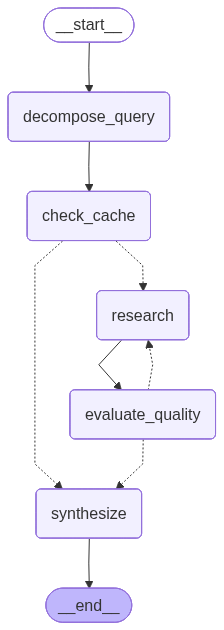

In [9]:
from IPython.display import Image, display

display(Image(workflow_app.get_graph().draw_mermaid_png()))

## Demo the Agent

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output visualizations generated may differ from those shown in the video.</p>

In [10]:
from agent import display_results
from agent import run_agent

### Scenario 1: Enterprise Platform Evaluation (cache building phase)


In [11]:
scenario1_query = """
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and compliance standards including SOC2 status, want to know the API rate 
limits for the Pro plan since we're considering that tier, need details about 
Salesforce integration capabilities, and want to understand your payment options 
including whether you support ACH transfers.
"""

result1 = run_agent(workflow_app, scenario1_query)
display_results(result1)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
I'm evaluating your platform for our enterprise n...'
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 36.50ms
INFO:agentic-workflow:   1. What are your security and compliance standards, including your SOC2 status?
INFO:agentic-workflow:   2. What are the API rate limits for the Pro plan?
INFO:agentic-workflow:   3. What are your Salesforce integration capabilities?
INFO:agentic-workflow:   4. What payment options do you offer, and do you support ACH transfers?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflow:   ❌ Cache MISS: 'What are your security and compli

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and com...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. 🔍 **RESEARCH**: What are your security and compliance standards, including your SOC2 status?
   2. 🔍 **RESEARCH**: What are the API rate limits for the Pro plan?
   3. 🔍 **RESEARCH**: What are your Salesforce integration capabilities?
   4. ✅ **CACHE HIT** (0.888): What payment options do you offer, and do you support ACH transfers?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **25.0%** (1/4 questions)
   🤖 LLM Calls: **8** (GPT-4: 2, GPT-4-Mini: 6)
   ⚡ Total Latency: **503.11ms**
   ⏱️  Cache: 147ms, Research: 244ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Thank you for considering our platform for your enterprise needs! I’m happy to provide a comprehensive overview addressing your questions about security, API limits, Salesforce integration, and payment options.

First, regarding security and compliance, our platform is SOC2 compliant and adheres to robust standards including end-to-end encryption, GDPR compliance, SSO integration, audit logs, and IP whitelisting. If you have any specific security requirements or need more detailed documentation, please let us know—we’re happy to provide additional information.

For the Pro plan, the API rate limit is 10,000 requests per hour, which should support most enterprise-level use cases. If you anticipate higher volumes or have unique integration needs, we can discuss custom solutions as well.

In terms of Salesforce integration, we offer native support for Salesforce, enabling seamless connectivity and interaction between our platform and your Salesforce environment. Additionally, you can leverage over 200 other integrations via Zapier to further extend Salesforce functionalities and automate workflows. If you have particular integration scenarios in mind, we’d be glad to discuss them in more detail.

Finally, for payment options, we accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers for orders over $100. This includes support for ACH transfers, making it convenient for enterprise transactions.

If you have any further questions or would like to schedule a demo or a deeper technical discussion, please let us know. We’re here to help ensure our platform meets all your enterprise requirements!

--------------------------------------------------------------------------------


### Scenario 2: Implementation Planning (partial cache hits likely)

In [12]:
scenario2_query = """
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro and Enterprise plans to decide on our tier, confirm the Salesforce 
integration capabilities we discussed, understand what data export options you provide 
for our migration needs, and verify the payment methods including ACH since our 
accounting team prefers that for monthly billing.
"""

result2 = run_agent(workflow_app, scenario2_query)
display_results(result2)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
We're moving forward with implementation planning...'
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 24.66ms
INFO:agentic-workflow:   1. What are the API rate limits for the Pro and Enterprise plans?
INFO:agentic-workflow:   2. What Salesforce integration capabilities are available?
INFO:agentic-workflow:   3. What data export options are provided for migration purposes?
INFO:agentic-workflow:   4. What payment methods are supported, specifically is ACH available for monthly billing?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflow:   ✅ Cache HIT: 'What are t

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro a...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. ✅ **CACHE HIT** (0.947): What are the API rate limits for the Pro and Enterprise plans?
   2. ✅ **CACHE HIT** (0.924): What Salesforce integration capabilities are available?
   3. 🔍 **RESEARCH**: What data export options are provided for migration purposes?
   4. ✅ **CACHE HIT** (0.857): What payment methods are supported, specifically is ACH available for monthly billing?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **75.0%** (3/4 questions)
   🤖 LLM Calls: **4** (GPT-4: 2, GPT-4-Mini: 2)
   ⚡ Total Latency: **325.29ms**
   ⏱️  Cache: 186ms, Research: 65ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Absolutely, I’m happy to provide a comprehensive overview to help with your implementation planning.

For API rate limits, the Pro plan allows up to 10,000 requests per hour. If you anticipate higher usage or need more flexibility, the Enterprise plan offers increased limits—please let us know your expected volume, and we can provide the exact numbers for Enterprise.

Regarding Salesforce integration, we offer native support for Salesforce, enabling seamless connectivity and interaction with your data. Additionally, you can leverage over 200 other integrations through Zapier, which can further extend Salesforce functionalities and automate workflows. If you have specific integration scenarios or requirements, I’d be glad to provide more detailed information.

For your migration needs, we support data exports in CSV, JSON, and XML formats. Please note that exports larger than 1GB may take up to 24 hours to process, so it’s a good idea to plan accordingly if you have a significant amount of data to migrate.

As for payment methods, we accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers (ACH) for orders over $100. This should align well with your accounting team’s preference for ACH on monthly billing.

If you need more details on any of these points or would like to discuss your specific use case further, please let me know—I’m here to help!

--------------------------------------------------------------------------------


### Scenario 3: Pre-Purchase Comprehensive Review (many cache hits expected)

In [13]:
scenario3_query = """
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance framework including SOC2 requirements, the exact API rate limits for the 
Pro plan we're purchasing, confirmation of the Salesforce integration features, all 
supported payment methods since we want to use ACH transfers, and your data export 
capabilities for our future migration planning.
"""

result3 = run_agent(workflow_app, scenario3_query)
display_results(result3)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
Before finalizing our Pro plan purchase, I need c...'
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 20.32ms
INFO:agentic-workflow:   1. What is your security compliance framework, specifically regarding SOC2 requirements?
INFO:agentic-workflow:   2. What are the exact API rate limits for the Pro plan we are considering?
INFO:agentic-workflow:   3. What Salesforce integration features are included with the Pro plan?
INFO:agentic-workflow:   4. What payment methods do you support, and do you accept ACH transfers?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflo

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance f...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. ✅ **CACHE HIT** (0.958): What is your security compliance framework, specifically regarding SOC2 requirements?
   2. ✅ **CACHE HIT** (0.971): What are the exact API rate limits for the Pro plan we are considering?
   3. 🔍 **RESEARCH**: What Salesforce integration features are included with the Pro plan?
   4. ✅ **CACHE HIT** (0.917): What payment methods do you support, and do you accept ACH transfers?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **75.0%** (3/4 questions)
   🤖 LLM Calls: **4** (GPT-4: 2, GPT-4-Mini: 2)
   ⚡ Total Latency: **333.80ms**
   ⏱️  Cache: 176ms, Research: 81ms
\n📋 **AI Response:**
--------------------------------------------------------------------

Thank you for reaching out with your detailed questions before finalizing your Pro plan purchase. I’m happy to provide a comprehensive overview to help with your decision:

1. Security Compliance Framework:  
We take security very seriously and adhere to robust standards, including SOC2 compliance. Our platform features end-to-end encryption, GDPR compliance, SSO integration, audit logs, and IP whitelisting to ensure your data is protected. If you need more in-depth documentation or have specific security questions, please let us know—we’re happy to provide further details.

2. API Rate Limits:  
With the Pro plan, you’ll have an API rate limit of 10,000 requests per hour. This should provide ample capacity for most integration and automation needs.

3. Salesforce Integration:  
The Pro plan includes native support for Salesforce integration. You can connect Salesforce directly to our platform without the need for additional middleware or tools. This integration is designed to work seamlessly and is supported within your API rate limits.

4. Supported Payment Methods (including ACH):  
We support all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers for orders over $100. ACH transfers are accepted as part of our bank transfer options, so you’ll be able to use this payment method for your purchase.

5. Data Export Capabilities:  
Our platform offers comprehensive data export features to support your future migration planning. You can export your data in standard formats, making it easy to migrate or back up your information as needed.

If you have any more questions or need specific documentation on any of these points, please let us know. We’re here to help ensure you have everything you need to move forward confidently with your Pro plan purchase.

--------------------------------------------------------------------------------


## Agent Performance Analysis


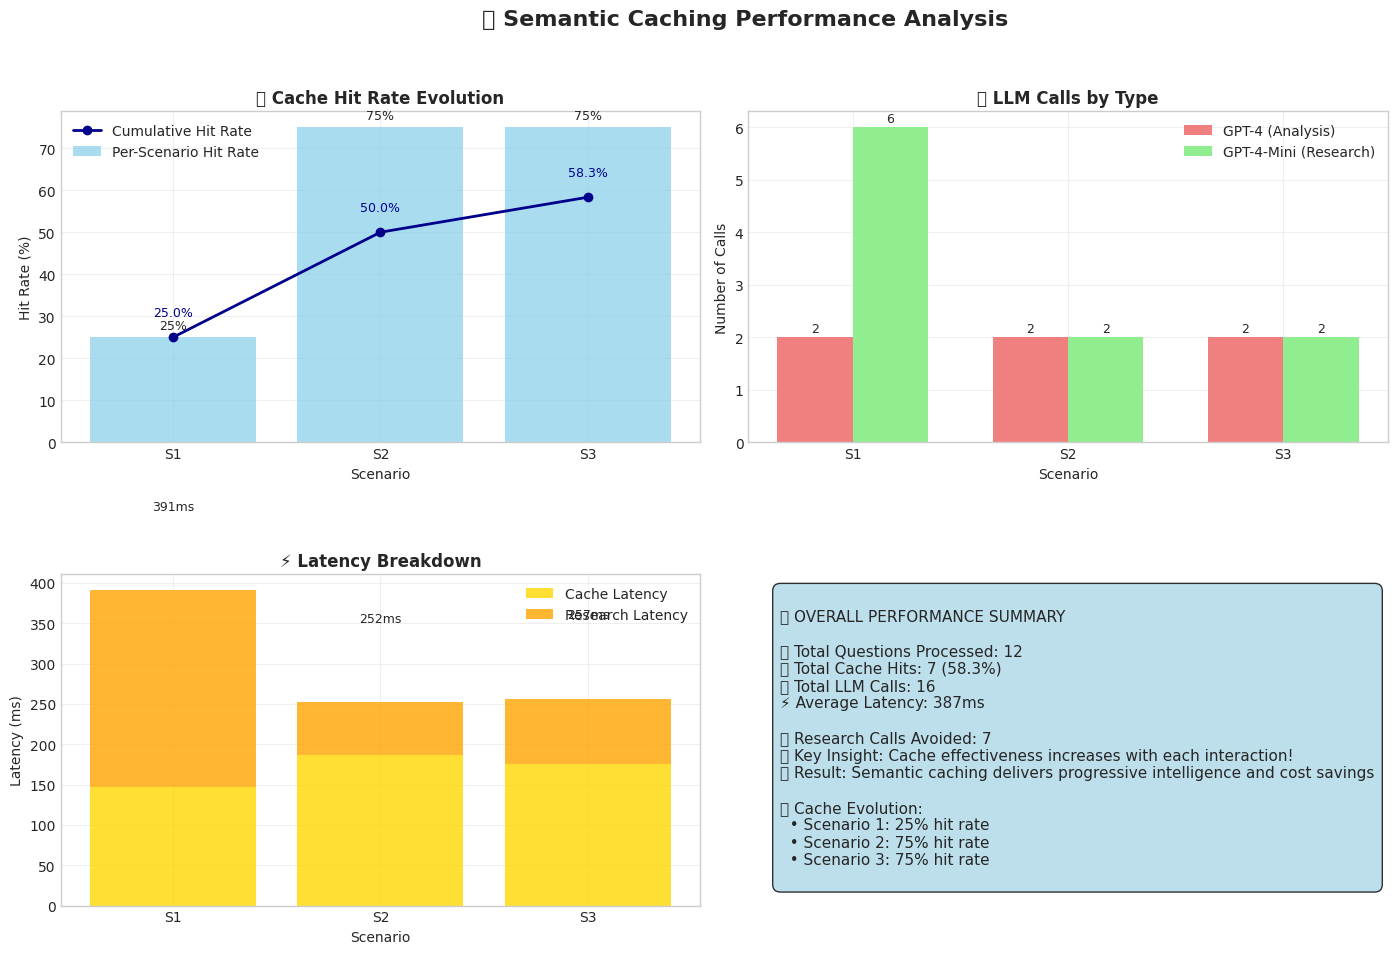

In [14]:
import warnings
warnings.simplefilter("ignore")

from agent import analyze_agent_results

total_questions, total_cache_hits = analyze_agent_results(
    [result1, result2, result3]
)

## Interactive Demo


Here is the link we used in the video for this section:
* https://att.com/international

In [15]:
from agent import launch_demo

launch_demo(
    workflow_app,
    cache,
    share=True,
    height=1500,
    inline=True
)

INFO:demo:Using Tavily API key from environment
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://s172-29-9-135p7860.lab-aws-production.deeplearning.ai/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://s172-29-9-135p7860.lab-aws-production.deeplearning.ai/ "HTTP/1.1 200 OK"


* Running on local URL:  https://0.0.0.0:7860


INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.3/frpc_linux_amd64 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://19a7ff5236849448f6.gradio.live "HTTP/1.1 200 OK"


* Running on public URL: https://19a7ff5236849448f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


INFO:demo:🧹 Complete reset: cleared knowledge bases and semantic cache
INFO:demo:Reset status: 🧹 Reset complete: ✅ Cleared 0 knowledge bases, semantic cache cleared
INFO:kb-utils:Split text into 1 chunks
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/embeddings "HTTP/1.1 200 OK"
INFO:kb-utils:✅ Created knowledge base with 1 chunks (text_chunked)
INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: 'I will go deep in the mountain in Alaska, is the c...'
INFO:httpx:HTTP Request: POST http://jupyter-api-proxy.internal.dlai/rev-proxy/openai/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Query is simple - keeping as single question
INFO:agentic-workflow:🧠 Kept as single question in 408.44ms
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache 

In [16]:
cache.cache.check(
    "checking cache", distance_threshold=1.0, num_results=100
)

[{'entry_id': '58ee5e823da0d485d3ad6ef9213810f3064e79bc10f61b7921efd57575fa13e8',
  'prompt': 'I will go deep in the mountain in Alaska, is the coverage good for my mobile call?\n',
  'response': "Mobile call coverage in the mountains of Alaska can be limited and is not guaranteed in all areas. Coverage depends on the specific location and the mobile carrier's network availability. It is advisable to check with your mobile carrier for detailed coverage maps and consider alternative communication options if you plan to go deep into remote mountain areas.",
  'vector_distance': 0.544106721878,
  'inserted_at': 1763646103.28,
  'updated_at': 1763646103.28,
  'key': 'semantic-cache:58ee5e823da0d485d3ad6ef9213810f3064e79bc10f61b7921efd57575fa13e8'}]